In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_20_epochs_ibm/harem
/media/discoD/models/elmo/ner/results_20_epochs_ibm/harem-ft


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            metrics[training_folder.name] = None

In [5]:
len(metrics)

600

In [6]:
len(configs)

600

In [7]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

In [8]:
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [9]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'

In [10]:
columns = [TRAINING_ID, SCENARIO, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]

In [11]:
columns

['Training_ID',
 'Scenario',
 'Model',
 'Embedding',
 'Batch_Size',
 'ELMo_Dropout',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [12]:
def get_elmo_dropout(config):
    return config['model']['text_field_embedder']['token_embedders']['elmo']['dropout']

def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 6:
        #No ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: get_elmo_dropout(config), TRAINING_NUMBER: data[4]}
    elif len(data) == 7:
        #With ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: data[4], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [13]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [14]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Scenario,Model,Embedding,Batch_Size,ELMo_Dropout,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,selective_harem_fasttext_64_0_0_0,selective,harem,fasttext,64,0,0,0,16,20,00:22:28,1348.0,67.40,0.998690,0.998791,0.983814,0.983549,0.983682,5.863632,0.980767,0.982625,0.807317,0.844388,0.825436,134.607131,0.978116,0.979647,0.822117,0.811686,0.816868,186.090374
1,selective_harem_fasttext_64_0_0_1,selective,harem,fasttext,64,0,0,1,11,20,00:22:24,1344.0,67.20,0.998645,0.998701,0.981931,0.981931,0.981931,5.495807,0.980111,0.982625,0.838542,0.821429,0.829897,123.037120,0.976315,0.978522,0.850730,0.759265,0.802399,176.680151
2,selective_harem_fasttext_64_0_0_2,selective,harem,fasttext,64,0,0,2,11,20,00:22:21,1341.0,67.05,0.998623,0.998713,0.981965,0.983819,0.982891,5.833987,0.980330,0.982953,0.837209,0.826531,0.831836,117.992419,0.977081,0.979197,0.848854,0.766945,0.805824,171.104209
3,selective_harem_fasttext_64_0_0_3,selective,harem,fasttext,64,0,0,3,11,20,00:22:18,1338.0,66.90,0.999026,0.999071,0.988140,0.988673,0.988407,5.302285,0.980002,0.982516,0.829016,0.816327,0.822622,118.874916,0.977156,0.979302,0.851316,0.766611,0.806746,172.580480
4,selective_harem_fasttext_64_0_0_4,selective,harem,fasttext,64,0,0,4,11,20,00:22:10,1330.0,66.50,0.998589,0.998701,0.983527,0.982201,0.982863,6.575225,0.980002,0.982625,0.834625,0.823980,0.829268,121.702032,0.976916,0.979032,0.848125,0.762604,0.803094,176.898042
5,selective_harem_fasttext_64_0_0_5,selective,harem,fasttext,64,0,0,5,17,20,00:22:25,1345.0,67.25,0.998690,0.998780,0.985946,0.983819,0.984881,5.980583,0.979128,0.981314,0.817734,0.846939,0.832080,156.841475,0.977801,0.979527,0.828283,0.793990,0.810774,179.091522
6,selective_harem_fasttext_64_0_1_0,selective,harem,fasttext,64,0,1,0,10,20,00:22:40,1360.0,68.00,0.998711,0.998779,0.984898,0.982513,0.983704,6.096981,0.989046,0.990241,0.897368,0.890339,0.893840,67.537650,0.977741,0.979632,0.831772,0.800668,0.815924,155.431331
7,selective_harem_fasttext_64_0_1_1,selective,harem,fasttext,64,0,1,1,10,20,00:22:43,1363.0,68.15,0.998394,0.998462,0.981193,0.982513,0.981852,6.720763,0.989444,0.990639,0.902632,0.895561,0.899083,68.277400,0.977531,0.979422,0.828601,0.798998,0.813531,155.118295
8,selective_harem_fasttext_64_0_1_2,selective,harem,fasttext,64,0,1,2,10,20,00:22:27,1347.0,67.35,0.998598,0.998688,0.985159,0.982244,0.983699,6.551463,0.988946,0.990141,0.893229,0.895561,0.894394,65.670149,0.978041,0.979887,0.833160,0.803673,0.818151,153.407797
9,selective_harem_fasttext_64_0_1_3,selective,harem,fasttext,64,0,1,3,16,20,00:22:35,1355.0,67.75,0.998813,0.998869,0.986516,0.984127,0.985320,5.618389,0.991038,0.992133,0.897368,0.890339,0.893840,68.782710,0.977981,0.979902,0.824315,0.803673,0.813863,184.636760


In [15]:
training_data_df = training_data_df[training_data_df.Scenario == 'selective']
len(training_data_df)

600

In [16]:
training_data_df.to_csv('training_data_20_epochs.csv')

In [17]:
training_data_df.groupby([MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem-ft,300.0,0.813074,0.005619,0.793138,0.809624,0.813505,0.816452,0.826608
harem,300.0,0.812728,0.005699,0.793651,0.809708,0.813073,0.816615,0.826494


In [18]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,120.0,0.814403,0.005823,0.796196,0.811535,0.814334,0.818066,0.826608
wang2vec,120.0,0.813924,0.006053,0.793138,0.810583,0.814556,0.817564,0.826124
none,120.0,0.812689,0.005391,0.799863,0.809108,0.812765,0.816647,0.823165
fasttext,120.0,0.812345,0.005017,0.799585,0.809789,0.813112,0.815979,0.822638
word2vec,120.0,0.811142,0.005433,0.796454,0.807613,0.811560,0.814978,0.826494


In [19]:
training_data_df.groupby([EMBEDDING, MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%       50%  \
Embedding Model                                                               
glove     harem-ft   60.0  0.815904  0.005565  0.796196  0.813461  0.815679   
wang2vec  harem      60.0  0.814325  0.006491  0.793651  0.810940  0.815848   
          harem-ft   60.0  0.813523  0.005608  0.793138  0.810473  0.813072   
none      harem-ft   60.0  0.813217  0.005494  0.801218  0.809616  0.813999   
glove     harem      60.0  0.812901  0.005731  0.799242  0.810451  0.813368   
fasttext  harem      60.0  0.812446  0.005506  0.799585  0.810677  0.813445   
          harem-ft   60.0  0.812244  0.004521  0.801701  0.809681  0.812468   
none      harem      60.0  0.812162  0.005278  0.799863  0.808582  0.811793   
word2vec  harem      60.0  0.811804  0.005249  0.800135  0.809159  0.812043   
          harem-ft   60.0  0.810480  0.005575  0.796454  0.806841  0.811006   

                         75%       max  
Embedding Model                         
glove     harem-ft  0.820244  0.826608  
wang2vec  harem     0.819446  0.825911  
          harem-ft  0.816136  0.826124  
none      harem-ft  0.817872  0.821664  
glove     harem     0.816297  0.824929  
fasttext  harem     0.816172  0.822638  
          harem-ft  0.815573  0.820013  
none      harem     0.816128  0.823165  
word2vec  harem     0.814957  0.826494  
          harem-ft  0.815032  0.820721

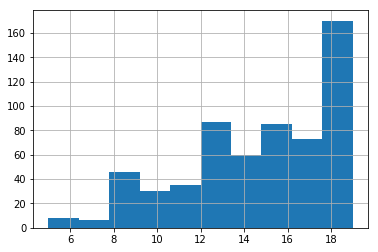

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count     600.000000
mean     1327.020000
std        44.693573
min       720.000000
25%      1315.000000
50%      1327.500000
75%      1342.000000
max      1481.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,60.0,0.817379,0.004672,0.804829,0.814010,0.817266,0.820578,0.826608
4,60.0,0.814128,0.005210,0.800135,0.810515,0.814865,0.817634,0.824570
7,60.0,0.813771,0.004706,0.797168,0.811285,0.814201,0.816225,0.824929
3,60.0,0.813727,0.004833,0.796454,0.811479,0.814295,0.816585,0.823165
6,60.0,0.813093,0.004917,0.803619,0.809540,0.813154,0.816136,0.825911
1,60.0,0.812906,0.006185,0.796196,0.809025,0.813254,0.818081,0.824207
8,60.0,0.812102,0.004333,0.803045,0.809669,0.812329,0.815178,0.821890
2,60.0,0.811337,0.005657,0.799863,0.806218,0.812500,0.814636,0.822117
0,60.0,0.810667,0.005498,0.799242,0.807569,0.811539,0.813724,0.822804


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,600.0,0.812901,0.005657,0.000231,0.812447,0.813354


In [24]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
harem,300,0.812728,0.005699,0.000329,0.812083,0.813372
harem-ft,300,0.813074,0.005619,0.000324,0.812438,0.813709


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,120,0.812345,0.005017,0.000458,0.811447,0.813243
glove,120,0.814403,0.005823,0.000532,0.813361,0.815444
none,120,0.812689,0.005391,0.000492,0.811725,0.813654
wang2vec,120,0.813924,0.006053,0.000553,0.812841,0.815007
word2vec,120,0.811142,0.005433,0.000496,0.810170,0.812114


In [26]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model    Embedding                                                       
harem    fasttext   60  0.812446  0.005506  0.000711   0.811053  0.813839
         glove      60  0.812901  0.005731  0.000740   0.811451  0.814351
         none       60  0.812162  0.005278  0.000681   0.810827  0.813498
         wang2vec   60  0.814325  0.006491  0.000838   0.812682  0.815967
         word2vec   60  0.811804  0.005249  0.000678   0.810475  0.813132
harem-ft fasttext   60  0.812244  0.004521  0.000584   0.811100  0.813388
         glove      60  0.815904  0.005565  0.000718   0.814496  0.817312
         none       60  0.813217  0.005494  0.000709   0.811826  0.814607
         wang2vec   60  0.813523  0.005608  0.000724   0.812104  0.814942
         word2vec   60  0.810480  0.005575  0.000720   0.809069  0.811890

In [27]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [35]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [36]:
print_anova(MODEL)

Overall model F( 1, 598) =  0.561, p =  0.45425607932819933588
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5607
Date:                Mon, 15 Apr 2019   Prob (F-statistic):              0.454
Time:                        16:39:10   Log-Likelihood:                 2254.3
No. Observations:                 600   AIC:                            -4505.
Df Residuals:                     598   BIC:                            -4496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [37]:
print_anova(EMBEDDING)

Overall model F( 4, 595) =  6.563, p =  0.00003585878067636826
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.563
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           3.59e-05
Time:                        16:39:32   Log-Likelihood:                 2267.0
No. Observations:                 600   AIC:                            -4524.
Df Residuals:                     595   BIC:                            -4502.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------